# Compute In-Band Spectral Indices of Detected Sources

In [1]:
import os
import numpy as np

from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import QTable
import astropy.units as u

from uncertainties import correlated_values
from uncertainties.umath import *

import matplotlib.pyplot as plt

## Define Functions

In [2]:
def get_target_pixel(hdu, target_coord_str):
    """Get the pixel number corresponding to the target coordinates

    Parameters
    ----------
    hdu : object
        FITS Header Data Unit as returned by astropy.fits.open()
    target_coord_str : str
        Coordinate string that can be accepted by astropy.coordinates.Skycoord()
        in units of hours (RA) and degrees (Dec)

    Returns
    -------
    tuple of floats
        target pixel
    """
    
    # Extract the image data and header
    image_header = hdu.header

    # Create a WCS object from the FITS header
    wcs = WCS(image_header)

    # Convert the target coordinate to SkyCoord object
    target_coord = SkyCoord(target_coord_str, unit=(u.hourangle, u.deg))

    # Convert the target coordinate to pixel coordinates
    target_pixel = wcs.all_world2pix(target_coord.ra.deg, target_coord.dec.deg, 0, 0, 1)
    
    # Round the pixel coordinates to the nearest integer
    target_pixel = np.round(target_pixel).astype(int) - np.array([1, 1, 1, 1])

    return target_pixel

def get_cutout(data, cutout, pc):
    """Get a cutour image of a given size at a given pixel coordinate

    Parameters
    ----------
    data : ndarray
        2D numpy data array
    cutout : int
        cutout size in number of pixels
    pc : tuple of ints
        pixel coordinates of cutout centre

    Returns
    -------
    ndarray
        2D numpy data array cutout
    """
    N = data.shape[0]

    nstart0 = max(pc[0] - cutout // 2, 0)
    nend0 = min(pc[0] + cutout // 2 + 1, N)
    nstart1 = max(pc[1] - cutout // 2, 0)
    nend1 = min(pc[1] + cutout // 2 + 1, N)

    return data[nstart0:nend0, nstart1:nend1]

def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    """2D Guassian function

    Parameters
    ----------
    xy : tuple of ndarrays
        x and y values (x, y) at which to evaluate 2D Gaussian
    amplitude : float
        amplitude of Gaussian
    xo : float
        x-mean of Gaussian
    yo : _type_
        y-mean of Gaussian
    sigma_x : float
        x standard deviation of Gaussian
    sigma_y : float
        y standard deviation of Gaussian
    theta : float
        position angle of 2D Gaussian

    Returns
    -------
    ndarray
        Values of 2D Gaussian evaluated at xy-coordinates.
    """
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
    c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
    g = amplitude * np.exp(- (a * ((x - xo)**2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo)**2)))

    return g.ravel()

def gauss_fit_2d(data, bounds):
    """Fit a 2D Gaussian to data

    Parameters
    ----------
    data : ndarray
        2D data array
    bounds : tuple
        bounds of (amplitude, x-mean, y-mean, x standard deviation, y standard deviation and position angle)
        given as a tuple of lists of 2 floats ([lower, upper], ...)

    Returns
    -------
    tuple
        best-fit parameters as returned by scipy.optimize.curve_fit()
    """
    N = data.shape[0]

    # Generate some sample data
    x = np.arange(-N//2, N//2)
    y = np.arange(-N//2, N//2)
    X, Y = np.meshgrid(x, y)

    # Perform the Gaussian fit
    popt, pcov = curve_fit(gaussian_2d, (X, Y), data.ravel(), p0=(0, 0, 0, 5, 5, 0), bounds=bounds)

    # Extract the fitted parameters
    return popt    

def model_spectrum(freq, log_S0, alpha):
    """Power-law spectrum

    Parameters
    ----------
    freq : ndarray of floats
        frequency data
    log_S0 : float
        log of flux at reference frequency 1.4 GHz
    alpha : float
        spectral index

    Returns
    -------
    ndarray of floats
        power-law spectrum evaluated at given frequencies
    """
    return 10**(log_S0) * (freq / 1.4e9) ** alpha

## Load Data and Perform Spectral Index Fitting

A power law,

\begin{equation}
S_\alpha(\nu) = 10^{x} \left(\frac{\nu}{\nu_0}\right)^\alpha,
\end{equation}
is fitted to the data, where $x=\log{S_0}$ is the logarithm of the flux density $S_0$ at the reference frequency $\nu_0$ and $\alpha$ is the spectral index. In addition to the best-fit spectra, we would like to provide the uncertainty of the fitted flux densities. This is achieved by computing the logarithm of the power-law,

\begin{equation}
\log{S_\alpha(\nu)} = x + \alpha \log{\left(\frac{\nu}{\nu_0}\right)},
\end{equation}
which is linear in the fitting parameters $x$ and $\alpha$, thus allowing for a straight-forward computation of the variance of $\log{S_\alpha(\nu)}$:

\begin{equation}
\mathrm{var}\left(\log{S_\alpha(\nu)}\right) = \mathrm{var}\left(x\right) + \mathrm{var}\left(\alpha\right) \log{\left(\frac{\nu}{\nu_0}\right)}^2 + 2\,\mathrm{cov}\left(x, \alpha\right)\log{\left(\frac{\nu}{\nu_0}\right)}
\end{equation}

The variances and covariances of the right-hand side of this equation are obtained from the numerical fitting procedure. The variance of $S_\alpha(\nu)$ can then be approximated as

\begin{equation}
\mathrm{var}\left(S_\alpha(\nu)\right) \approx \mathrm{var}\left(\log{S_\alpha(\nu)}\right) \left(S_\alpha(\nu) \ln{10}\right)^2
\end{equation}
which makes use of standard linear propagation of uncertainties. The standard deviations

\begin{align}
\sigma_S(\nu) &= \sqrt{\mathrm{var}\left(S_\alpha(\nu)\right)}\\
\sigma_{\log{S}}(\nu) &= \sqrt{\mathrm{var}\left(\log{S_\alpha(\nu)}\right)}
\end{align}
define the uncertainties of the (log) flux density and $[\log{S_\alpha(\nu)} - 2\sigma_{\log{S}}(\nu), \log{S_\alpha(\nu)} + 2\sigma_{\log{S}}(\nu)]$ defines the $\approx95\%$ confidence bands of the fit as shown in th plot below.



In [3]:
# list of objects on which to perform spectral index fitting
obsnames = ["QSO-J1427+3312", "QSO-J1429+5447", "QSO-J2318-3113"]

# read quasar catalogue
qso_catalog = QTable.read('../tables/Quasar_catalog_Banados+16_Matsuoka+19a_Matsuoka+19b_Wang+18_Wang+19_Reed+19_Yang+20.txt', format='ascii')

# creat empty dictory to store fitting results
obs_dict = {}

for obsname in obsnames:
    catalog_name = list(obsname)
    catalog_name[3] = "_"
    catalog_name = "".join(catalog_name)
    
    qso_data = qso_catalog[qso_catalog["QSO-Name"] ==  catalog_name]

    fluxints = []
    freqs = []
    mad_list = []
    peaks = []

    for i in range(9):
        # read FITS data
        imfits = os.path.join(f"/rds/user/pmk46/hpc-work/19A-056/imaging/{obsname}/clean/", f"{obsname}-res.im-000{i}-image.fits")
        hdu = fits.open(imfits)[0]
        header = hdu.header
        image_data = hdu.data[0, 0]
        
        # get image cutout
        Nsmall = 9
        ra = qso_data["RA"].value[0]
        dec = qso_data["Dec"].value[0]
        pc = get_target_pixel(hdu, f"{ra} {dec}")[[0, 1]]
        peak = image_data[pc[0], pc[1]]
        image_data_small = get_cutout(image_data, Nsmall, pc)
        image_data = get_cutout(image_data, 128, pc)
        mad_list.append(np.median(1.4826 * np.abs(image_data - np.median(image_data))))

        beam = header["BMIN"] * header["BMAJ"] / (header["CDELT2"] * 2.355)**2
        amplitude, x_mean, y_mean, x_stddev, y_stddev, theta = gauss_fit_2d(image_data_small, bounds=([-1e5, -4, -4, 1, 1, -np.pi/4], [1e5, 4, 4, 8, 8, np.pi/4]))
        fluxint = (amplitude * x_stddev * y_stddev / beam)
        
        freqs.append(header["CRVAL3"])
        fluxints.append(fluxint)
        peaks.append(peak)

    # Perform spectral index fit
    params, cov = curve_fit(model_spectrum, freqs, peaks, sigma=mad_list)
    log_S0, alpha = params
    S0 = 10**log_S0
    reg_band = lambda freq, nsig: nsig * np.sqrt(cov[0, 0] + np.log10(freq / 1.4e9) * (np.log10(freq / 1.4e9) * cov[1, 1] + cov[0, 1] + cov[1, 0]))
    obs_dict.update({obsname: (freqs, fluxints, peaks, mad_list, S0, alpha, cov, reg_band)})
    
    ulog_S0, ualpha = correlated_values([log_S0, alpha], cov)
    print(f"log10(S0) = {ulog_S0}, alpha = {ualpha}, S0 = {model_spectrum(1.4e9, ulog_S0, alpha) * 1000} mJy")

log10(S0) = -2.809+/-0.017, alpha = -1.43+/-0.22, S0 = 1.55+/-0.06 mJy


log10(S0) = -2.480+/-0.010, alpha = -0.73+/-0.12, S0 = 3.31+/-0.08 mJy


log10(S0) = -3.11+/-0.04, alpha = -1.5+/-0.5, S0 = 0.78+/-0.07 mJy


## Print Fitting Results
Check error propagation. The error of the fitted flux density is propagated as follows: $\sigma_S \approx \sigma_{\log_{10}{S}} \times S \log_{10}$.

In [4]:
for obs in obs_dict:
    print(f"{obs}: S0 = {obs_dict[obs][4]*1000} mJy, std(S0) = {np.sqrt(obs_dict[obs][6][0, 0]) * obs_dict[obs][4] * np.log(10)*1000} mJy, alpha = {obs_dict[obs][5]}, std(alpha) = {obs_dict[obs][6][1, 1]}")

QSO-J1427+3312: S0 = 1.5517420689017276 mJy, std(S0) = 0.06038547564646013 mJy, alpha = -1.4331179937577232, std(alpha) = 0.0500936823868338
QSO-J1429+5447: S0 = 3.310523654438719 mJy, std(S0) = 0.07506201425068895 mJy, alpha = -0.7297839704477525, std(alpha) = 0.013994476454448275
QSO-J2318-3113: S0 = 0.7760049754624223 mJy, std(S0) = 0.07151523693863672 mJy, alpha = -1.476846952547392, std(alpha) = 0.2588834847897556


## Plot Fitting Results

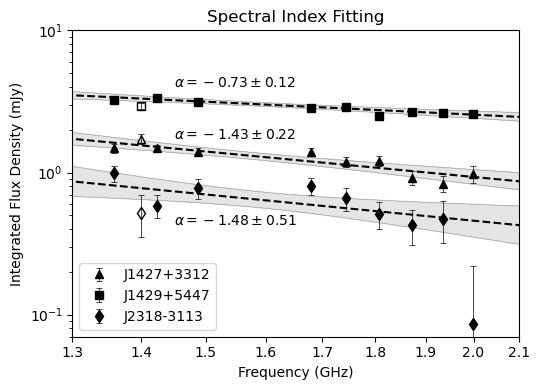

In [5]:
fig = plt.figure(figsize=(5.5, 4))

# define colors and markers for the different sources
colors = ["k", "k", "k"]
markers = ["^", "s", "d"]

for obsname, color, marker in zip(obs_dict, colors, markers):
    (freqs, fluxints, peaks, mad_list, S0, alpha, cov, reg_band) = obs_dict[obsname]
    sig_alpha = cov[1, 1]

    x = np.linspace(0.1, 4.1, 1000) * 1e9
    y = model_spectrum(x, np.log10(S0), alpha)

    # plot data points
    plt.errorbar(np.array(freqs) / 1e9, np.array(fluxints) * 1e3, yerr=np.array(mad_list) * 1e3, fmt=marker, color=color, label=obsname[4:], capsize=2, capthick=.5, elinewidth=.5)
    
    # plot regression line and bands
    plt.plot(x / 1e9, y * 1e3, color=color, linestyle="--")
    plt.plot(x / 1e9, y * 10**reg_band(x, 2) * 1e3, color=color, linestyle="-", linewidth=.1)
    plt.plot(x / 1e9, y / 10**reg_band(x, 2) * 1e3, color=color, linestyle="-", linewidth=.1)
    plt.fill_between(x / 1e9, y * 10**reg_band(x, 2) * 1e3, y / 10**reg_band(x, 2) * 1e3, color=color, alpha=0.1)

    # print spectral indices
    if obsname[4:] == "J2318-3113":
        plt.text(1.45, model_spectrum(1.56e9, np.log10(S0), alpha) * 1.3e3 / 2, rf"$\alpha={alpha.round(2)}\pm{np.sqrt(cov[1,1]).round(2)}$", color=color)
    else:
        plt.text(1.45, model_spectrum(1.56e9, np.log10(S0), alpha) * 1.3e3, rf"$\alpha={alpha.round(2)}\pm{np.sqrt(cov[1,1]).round(2)}$", color=color)

# add literature values
plt.errorbar(1.4, 1.730, yerr=0.131, fmt=markers[0], color="k", fillstyle="none", capsize=2, capthick=.5, elinewidth=.5)
plt.errorbar(1.4, 2.930, yerr=0.152, fmt=markers[1], color="k", fillstyle="none", capsize=2, capthick=.5, elinewidth=.5)
plt.errorbar(1.4, 0.52, yerr=0.17, fmt=markers[2], color="k", fillstyle="none", capsize=2, capthick=.5, elinewidth=.5)
plt.errorbar(3, 1.822, yerr=0.194, fmt=markers[1], color="k", fillstyle="none", capsize=2, capthick=.5, elinewidth=.5, markersize=6)
plt.errorbar(0.144, 5.873, yerr=0.083, fmt=markers[0], color="k", fillstyle="none", capsize=2, capthick=.5, elinewidth=.5, markersize=6)

# format and save plot
plt.xscale("log")
plt.yscale("log")
plt.xlim([1.3, 2.1])
plt.ylim([7e-2, 1e1])
plt.xlabel("Frequency (GHz)")
plt.ylabel("Integrated Flux Density (mJy)")
plt.title("Spectral Index Fitting")
plt.minorticks_on()
plt.legend(loc=3)
plt.xticks(np.arange(1.3, 2.2, 0.1), np.arange(1.3, 2.2, 0.1).round(1))
plt.tight_layout()
plt.savefig("../../plots/spix.pdf")